# AMATH 482 Homework 5 - *Compressed Image Recovery*

## Lang Qin

# 0 Environment Setup

We first connect our notebook to personal google drive.

In [ ]:
from google.colab import drive

# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')

Mounted at /content/drive


Import all packages necessary for this project.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski

import skimage.io
import skimage.transform

import scipy.fftpack as spfft # for discrete cosine transform 

Then, we read in the given the dataset and rescale the image by $53×41$. 

**Note:** All following work is doen with the recaled image.


Original size:  (292, 228)
Rescaled size:  (53, 41)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  


Text(0.5, 1.0, 'Rescaled image')

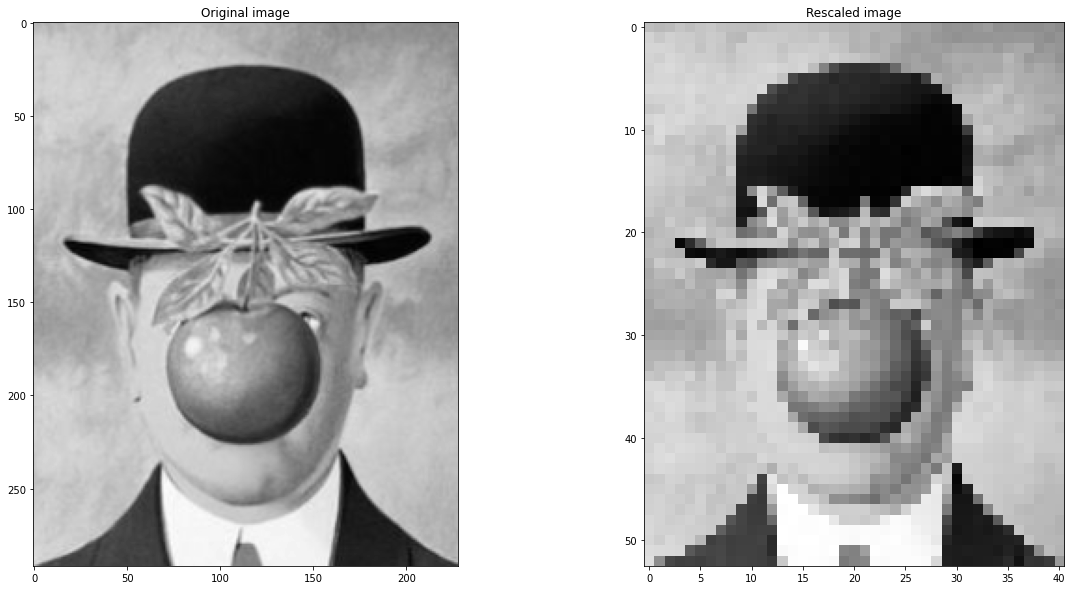

In [ ]:
# import image and rescale 
img_path = '/content/drive/My Drive/AMATH 482/HW5/SonOfMan.png'

# read image
img_og = ski.io.imread(img_path)

# convert to grayscale and visualize 
img_og = ski.color.rgb2gray(img_og)

# preview the original and resized images
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(img_og, cmap = 'gray')
ax[0].set_title("Original image")

print("Original size: ", img_og.shape)

# resize image 
img = ski.transform.rescale(img_og, 0.18, anti_aliasing=False)

print("Rescaled size: ", img.shape)

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image")

# 1 Image Compression

The goal is to investigate the compressibility of the discrete cosine
transform (DCT) of $\verb|SonOfMan.png|$.

The first step is to construct forward and inverse DCT matrices.

In [ ]:
# construct forward DCT matrix
def construct_DCT_Mat(Nx, Ny):
  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: D DCT matrix mapping image.flatten() to 
  #         DCT(image).flatten()

  Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')

  D = np.kron(Dy, Dx)

  return D


# construct inverse DCT matrix
def construct_iDCT_Mat(Nx, Ny):
  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: iD iDCT matrix mapping DCT(image).flatten() to 
  #         image.flatten()

  Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')

  D = np.kron(Dy, Dx)

  return D

**1 (a)** Construct forward and inverse DCT matrices for the image. 

In [ ]:
# Vectorize the image
img_flat = img.flatten()

# forward DCT matrix
DCT_forward = np.dot(construct_DCT_Mat(41, 53), img_flat)

# inverse DCT matrix
DCT_inverse = construct_iDCT_Mat(41, 53)

**1 (b)** Plot DCT(𝐹) and investigate its compressibility.

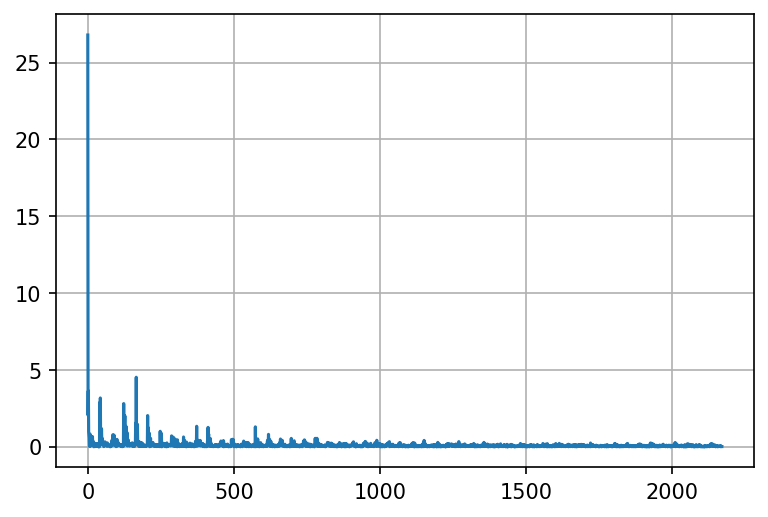

In [ ]:
# Plot DCT(F)
fig = plt.figure(dpi=150)
ax = plt.axes()
ax.plot(abs(DCT_forward))
ax.grid()

**1 (c)** Reconstruct and plot the image after thresholding its DCT to keep the top 5, 10, 20, and 40 percent of DCT coefficients.

Threshold coefficients:  [0.29677101953791735, 0.20936298703736805, 0.14197325805533959, 0.083307028438665]


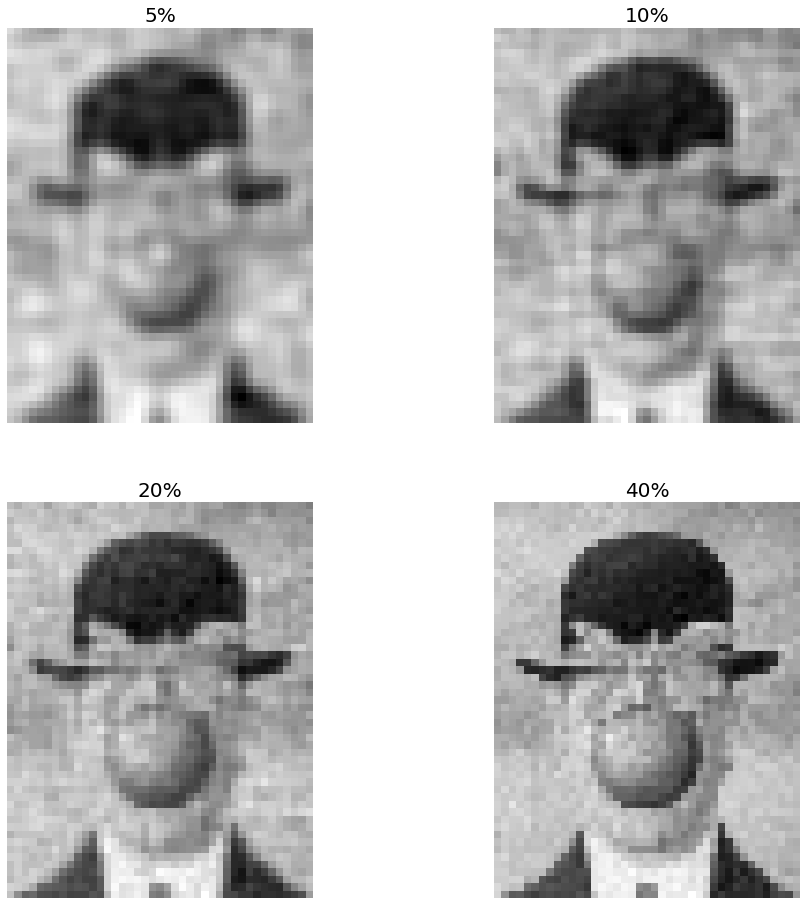

In [ ]:
# initialize threshold
thresholds = [5, 10, 20, 40]

# generate compressed images
coeffs = []
images = []
for i in range(4):
    coeffs.append(np.percentile(np.abs(DCT_forward), (100 - thresholds[i])))
    curr = DCT_forward.copy()
    curr[abs(curr) < coeffs[i]] = 0
    curr = np.dot(DCT_inverse, curr)
    images.append(curr.reshape(53, 41))

# preview threshold coefficients
print("Threshold coefficients: ", coeffs)

# plot the images
Titles = ['5%', '10%', '20%', '40%']
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
count = 0
for j in range(2):
    for jj in range(2):
        ax[j, jj].imshow(images[count], cmap='gray')
        ax[j, jj].set_title(Titles[count], fontsize=20)
        ax[j, jj].axis('off')
        count = count + 1

# 2 Compressed Image Recovery on the Son of Man

**2 (a)(b)(c)** A decompression function is necessary to be defined.

In [ ]:
def decompress(r):
    # construct measurement matrix B
    N = img_flat.shape[0]
    M = int(r * N)
    B = np.random.permutation(np.eye(N))[0:M, :]

    # vector measurement
    y = np.dot(B, img_flat)
    A = np.dot(B, DCT_inverse)

    # solve optimization problem
    vb = cvx.Variable(N)
    obj = cvx.Minimize(cvx.norm(vb, 1))
    const = [A*vb == y]
    prob = cvx.Problem(obj, const)
    result = prob.solve(verbose=True,
                solver='CVXOPT',
                max_iter=1000,
                reltol=1e-2,
                featol=1e-2)
    
    return np.dot(DCT_inverse, vb.value).reshape(53, 41)

**2 (d)** Take 𝑀 = 𝑟 × 𝑁 for 𝑟 = 0.2, 0.4, 0.6. For each choice of 𝑀 perform the steps (2a-2c) above to obtain an approximation 𝐹* to 𝐹 and repeat these calculations three times by re-drawing the random matrix 𝐵. 

Present a plot of these images and discuss your
results.

     pcost       dcost       gap    pres   dres   k/t
 0:  4.8880e-15 -1.5010e-15  1e+04  4e+02  4e-16  1e+00
 1:  3.1815e+01  3.1944e+01  6e+03  2e+02  3e-16  6e-01
 2:  4.7097e+01  4.7424e+01  2e+03  6e+01  2e-16  5e-01
 3:  7.1418e+01  7.1571e+01  1e+03  3e+01  2e-16  2e-01
 4:  9.7554e+01  9.7616e+01  4e+02  1e+01  3e-16  9e-02
 5:  1.1815e+02  1.1817e+02  2e+02  5e+00  4e-16  4e-02
 6:  1.2743e+02  1.2744e+02  7e+01  2e+00  4e-16  2e-02
 7:  1.3131e+02  1.3132e+02  3e+01  1e+00  5e-16  7e-03
 8:  1.3325e+02  1.3325e+02  1e+01  4e-01  5e-16  3e-03
 9:  1.3410e+02  1.3411e+02  5e+00  2e-01  5e-16  1e-03
10:  1.3443e+02  1.3443e+02  2e+00  6e-02  5e-16  4e-04
11:  1.3455e+02  1.3455e+02  8e-01  2e-02  5e-16  2e-04
12:  1.3460e+02  1.3460e+02  3e-01  9e-03  5e-16  7e-05
13:  1.3462e+02  1.3462e+02  1e-01  4e-03  6e-16  3e-05
14:  1.3463e+02  1.3463e+02  4e-02  1e-03  8e-16  8e-06
15:  1.3463e+02  1.3463e+02  9e-03  3e-04  6e-16  2e-06
16:  1.3463e+02  1.3463e+02  3e-03  1e-04  7e-16  

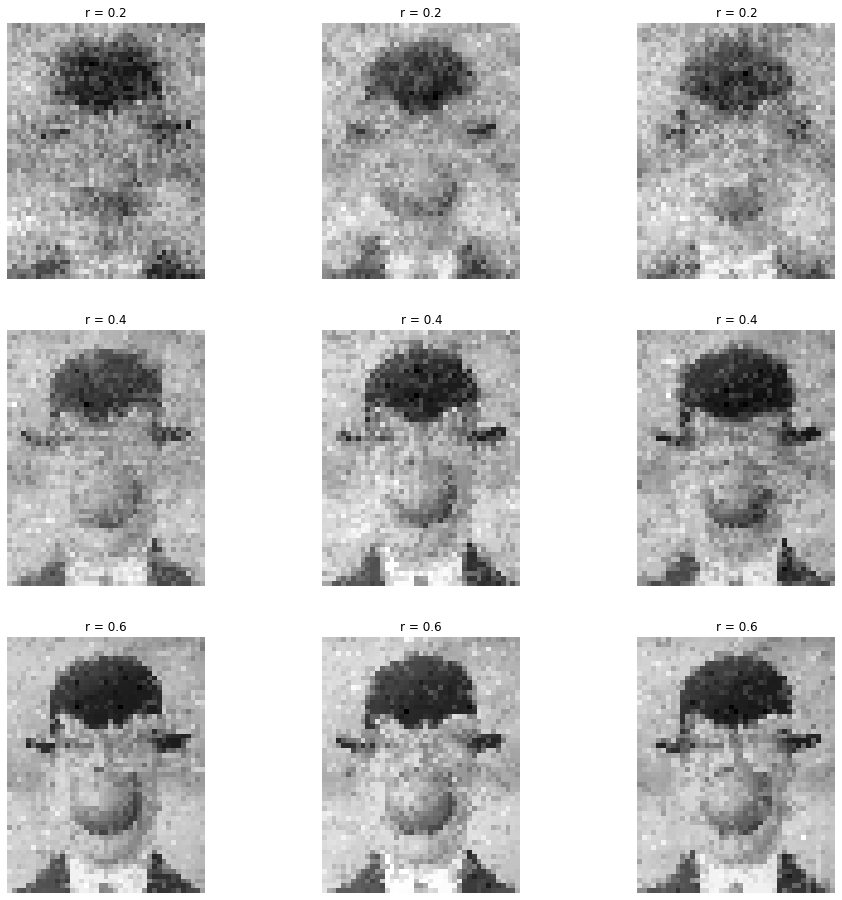

In [ ]:
# initialize canva
fig, ax = plt.subplots(3, 3, figsize=(16, 16))

# initialize r
r = [0.2, 0.4, 0.6]
Titles = ["r = 0.2", "r = 0.4", "r = 0.6"]

# perform image recovery
images_recovered = []
for i in range(3):
    for j in range(3):
        curr = decompress(r[i])
        images_recovered.append(curr)
        ax[i][j].imshow(curr, cmap='gray')
        ax[i][j].set_title(Titles[i])
        ax[i][j].axis('off')

# 3 A Mysterious Image

Read the mystery file and reconstruct the image.

In [ ]:
# import image and rescale 
mystery_path = '/content/drive/My Drive/AMATH 482/HW5/UnknownImage.npz'

# read image
mystery_data = np.load(mystery_path)
B = mystery_data['B.npy']
y = mystery_data['y.npy']

print("Shape of B: ", B.shape)
print("Shape of y: ", y.shape)

Shape of B:  (2000, 2500)
Shape of y:  (2000,)


Then, perform image recovery process to retrieve the image.

It is known that the image is of $50\times50$.

In [ ]:
from re import VERBOSE
mystery_inverse = construct_iDCT_Mat(50, 50)

# reconstruct the optimization problem
A = np.dot(B, mystery_inverse)
vb = cvx.Variable(2500)
obj_mys = cvx.Minimize(cvx.norm(vb, 1))
const_mys = [A*vb == y]
prob_mys = cvx.Problem(obj_mys, const_mys)

# solve for optimal solution
opt_mys = prob_mys.solve(verbose=True)

Generate the reconstructed image.

Text(0.5, 1.0, 'Reconstructed Mystery Image')

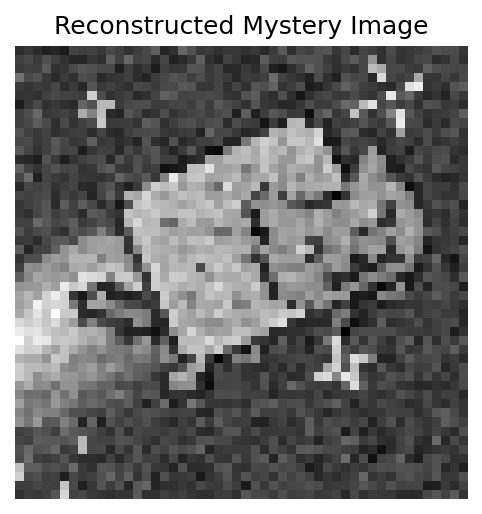

In [ ]:
# generate the image
mystery_image = np.dot(mystery_inverse, vb.value).reshape(50,50)

# plot the image
fig = plt.figure(dpi = 150)
ax = plt.axes()
ax.axis('off')
ax.imshow(mystery_image, cmap='gray')
ax.set_title('Reconstructed Mystery Image')